In [1]:
# This file will implement the main training loop for a model
# Model 1
from time import time
import sys
import os
import argparse
# os.chdir('..')
print(os.getcwd())
#sys.path.append('../..')

from torch import device
import torch
from torch import optim
import numpy as np

from data_prep import NLIGenData2 as Data
from disentanglement_transformer.models import DisentanglementTransformerVAE as Model
from disentanglement_transformer.h_params import DefaultTransformerHParams as HParams
from disentanglement_transformer.graphs import *
from disentanglement_transformer.graphs import get_structured_auto_regressive_graph
from components.criteria import *
parser = argparse.ArgumentParser()

# Training and Optimization
parser.add_argument("--test_name", default='nliLM/StructuredAutoreg5', type=str)
parser.add_argument("--max_len", default=17, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=10000, type=int)
parser.add_argument("--test_freq", default=32, type=int)
parser.add_argument("--complete_test_freq", default=160, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=128, type=int)#################"
parser.add_argument("--z_size", default=768, type=int)#################"
parser.add_argument("--n_latents", default=[16, 16, 16], type=int)#################"
parser.add_argument("--text_rep_l", default=2, type=int)
parser.add_argument("--text_rep_h", default=768, type=int)
parser.add_argument("--encoder_h", default=768, type=int)#################"
parser.add_argument("--encoder_l", default=2, type=int)#################"
parser.add_argument("--decoder_h", default=768, type=int)
parser.add_argument("--decoder_l", default=3, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE"], type=str)
parser.add_argument("--training_iw_samples", default=5, type=int)
parser.add_argument("--testing_iw_samples", default=20, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=2000, type=int)
parser.add_argument("--anneal_kl1", default=4000, type=int)
parser.add_argument("--grad_clip", default=100., type=float)
parser.add_argument("--kl_th", default=0/(768*3), type=float or None)
parser.add_argument("--dropout", default=0.0, type=float)
parser.add_argument("--word_dropout", default=.0, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=3, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()

# torch.autograd.set_detect_anomaly(True)
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo]}[flags.losses]
#  LOSSES = [IWLBo]
ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]

data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, False)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos), MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs={'lr': flags.lr, #'weight_decay': flags.l2_reg, 't0':100, 'lambd':0.},
                                     'weight_decay': flags.l2_reg, 'betas': (0.9, 0.85)},
                   is_weighted=[], graph_generator=get_structured_auto_regressive_graph,
                   z_size=flags.z_size, embedding_dim=flags.embedding_dim, anneal_kl=ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=optim.AdamW,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type)
print("Loss Type: ", flags.losses)
model = Model(data.vocab, data.tags, h_params, wvs=data.wvs)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
print("Unsupervised training examples: ", total_unsupervised_train_samples)
current_time = time()
#print(model)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))


E:\Experiments\GLUE_BENCH


error loading _jsonnet (this is expected on Windows), treating C:\Users\ghazy\AppData\Local\Temp\tmpfpvn84vs\config.json as plain json


Mean length:  8.900745464443235  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  8. 10. 13. 14. 15.] std: 2.6633922182479695 n_examples: 90011
Mean length:  8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6612292456585793 n_examples: 10003


Mean length:  8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6612292456585793 n_examples: 10003


Words:  11895 , On device:  cuda
Loss Type:  VAE


Loaded model at step 25936
Unsupervised training examples:  90112
Number of parameters:  03.77 M
Inference parameters:  02.21 M
Generation parameters:  03.08 M
Embedding parameters:  01.52 M


In [ ]:
# Model 2
import sys
import os
import argparse
print(os.getcwd())
#sys.path.append('../..')
# os.chdir('../..')

from torch import device
import torch
from torch import optim
import numpy as np

from data_prep import NLIGenData2 as Data
from disentanglement_transformer.models import DisentanglementTransformerVAE as Model
from disentanglement_transformer.h_params import DefaultTransformerHParams as HParams
from disentanglement_transformer.graphs import *
from components.criteria import *
parser = argparse.ArgumentParser()

# Training and Optimization
# k, kz =1, 10
# parser.add_argument("--test_name", default='unnamed', type=str)
# parser.add_argument("--max_len", default=20, type=int)
# parser.add_argument("--batch_size", default=512, type=int)
# parser.add_argument("--grad_accu", default=1, type=int)
# parser.add_argument("--n_epochs", default=10000, type=int)
# parser.add_argument("--test_freq", default=32, type=int)
# parser.add_argument("--complete_test_freq", default=32, type=int)
# parser.add_argument("--generation_weight", default=1, type=float)
# parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
# parser.add_argument("--embedding_dim", default=300, type=int)#################"
# parser.add_argument("--pretrained_embeddings", default=True, type=bool)#################"
# parser.add_argument("--z_size", default=768*kz, type=int)#################"
# parser.add_argument("--z_emb_dim", default=768*k, type=int)#################"
# parser.add_argument("--n_latents", default=[16, 16, 16], type=list)#################"
# parser.add_argument("--text_rep_l", default=2, type=int)
# parser.add_argument("--text_rep_h", default=768*k, type=int)
# parser.add_argument("--encoder_h", default=768*k, type=int)#################"
# parser.add_argument("--encoder_l", default=2, type=int)#################"
# parser.add_argument("--decoder_h", default=768*k, type=int)
# parser.add_argument("--decoder_l", default=2, type=int)#################"
# parser.add_argument("--highway", default=False, type=bool)
# parser.add_argument("--markovian", default=True, type=bool)
# parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE"], type=str)
# parser.add_argument("--graph", default='Discrete', choices=["Discrete", "Normal"], type=str)
# parser.add_argument("--training_iw_samples", default=5, type=int)
# parser.add_argument("--testing_iw_samples", default=20, type=int)
# parser.add_argument("--test_prior_samples", default=10, type=int)
# parser.add_argument("--anneal_kl0", default=3000, type=int)
# parser.add_argument("--anneal_kl1", default=6000, type=int)
# parser.add_argument("--grad_clip", default=10., type=float)
# parser.add_argument("--kl_th", default=0*12/(1536*28/16), type=float or None)
# parser.add_argument("--dropout", default=0.0, type=float)
# parser.add_argument("--word_dropout", default=.0, type=float)
# parser.add_argument("--l2_reg", default=0, type=float)
# parser.add_argument("--lr", default=2e-4, type=float)
# parser.add_argument("--lr_reduction", default=4., type=float)
# parser.add_argument("--wait_epochs", default=3, type=float)
# parser.add_argument("--save_all", default=True, type=bool)
# 
# flags, _ = parser.parse_known_args()
# 
# # Manual Settings, Deactivate before pushing
# if True:
#     flags.losses = 'VAE'
#     flags.batch_size = 64
#     flags.grad_accu = 1
#     flags.max_len = 17
#     flags.test_name = "nliLM/Discrete3"

k, kz = 1, 1
parser.add_argument("--test_name", default='unnamed', type=str)
parser.add_argument("--max_len", default=20, type=int)
parser.add_argument("--batch_size", default=512, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=10000, type=int)
parser.add_argument("--test_freq", default=32, type=int)
parser.add_argument("--complete_test_freq", default=160, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=300, type=int)#################"
parser.add_argument("--pretrained_embeddings", default=True, type=bool)#################"
parser.add_argument("--z_size", default=768*kz, type=int)#################"
parser.add_argument("--z_emb_dim", default=768*k, type=int)#################"
parser.add_argument("--n_latents", default=[4, 4, 4], type=list)#################"
parser.add_argument("--text_rep_l", default=2, type=int)
parser.add_argument("--text_rep_h", default=768*k, type=int)
parser.add_argument("--encoder_h", default=768*k, type=int)#################"
parser.add_argument("--encoder_l", default=1, type=int)#################"
parser.add_argument("--decoder_h", default=768*k, type=int)
parser.add_argument("--decoder_l", default=2, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE"], type=str)
parser.add_argument("--graph", default='Normal', choices=["Discrete", "Normal"], type=str)
parser.add_argument("--training_iw_samples", default=5, type=int)
parser.add_argument("--testing_iw_samples", default=20, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=00, type=int)
parser.add_argument("--anneal_kl1", default=3000, type=int)
parser.add_argument("--grad_clip", default=10., type=float)
parser.add_argument("--kl_th", default=0/(768*k/2), type=float or None)
parser.add_argument("--dropout", default=0.0, type=float)
parser.add_argument("--word_dropout", default=.0, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=6, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()

# Manual Settings, Deactivate before pushing
if True:
    flags.losses = 'VAE'
    flags.batch_size = 64
    flags.grad_accu = 1
    flags.max_len = 17
    flags.test_name = "nliLM/NormalRe2"

# torch.autograd.set_detect_anomaly(True)
GRAPH = {"Discrete": get_discrete_auto_regressive_disentanglement_graph,
         "Normal": get_structured_auto_regressive_disentanglement_graph}[flags.graph]
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
MAS_ELBO = 5
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo]}[flags.losses]
#  LOSSES = [IWLBo]
ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]

data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, flags.pretrained_embeddings)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos), MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs={'lr': flags.lr, #'weight_decay': flags.l2_reg, 't0':100, 'lambd':0.},
                                     'weight_decay': flags.l2_reg, 'betas': (0.9, 0.85)},
                   is_weighted=[], graph_generator=GRAPH,
                   z_size=flags.z_size, embedding_dim=flags.embedding_dim, anneal_kl=ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=optim.AdamW,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents, max_elbo=5,
                   z_emb_dim=flags.z_emb_dim)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type)
print("Loss Type: ", flags.losses)
model = Model(data.vocab, data.tags, h_params, wvs=data.wvs)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
print("Unsupervised training examples: ", total_unsupervised_train_samples)
current_time = time()
#print(model)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))

E:\Experiments\GLUE_BENCH


Mean length:  8.900745464443235  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  8. 10. 13. 14. 15.]


Mean length:  8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.]
Mean length:  8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.]


Words:  11895 , On device:  cuda
Loss Type:  VAE


Loaded model at step 116781
Unsupervised training examples:  90048
Number of parameters:  13.13 M
Inference parameters:  06.42 M
Generation parameters:  10.28 M
Embedding parameters:  03.57 M


In [2]:
model.eval()
def decode_to_text(x_hat_params, vocab_size, vocab_index):
    # It is assumed that this function is used at test time for display purposes
    # Getting the argmax from the one hot if it's not done
    while x_hat_params.shape[-1] == vocab_size and x_hat_params.ndim > 3:
        x_hat_params = x_hat_params.mean(0)
    while x_hat_params.ndim > 2 and x_hat_params.shape[-1] != self.h_params.vocab_size:
        x_hat_params = x_hat_params[0]
    if x_hat_params.shape[-1] == vocab_size:
        x_hat_params = torch.argmax(x_hat_params, dim=-1)
    assert x_hat_params.ndim == 2, "Mis-shaped generated sequence: {}".format(x_hat_params.shape)
    
    samples = [' '.join([vocab_index.itos[w]
                         for w in sen]).split('<eos>')[0].replace('<go>', '').replace('</go>', '')
               .replace('<pad>', '_').replace('_unk', '<?>')
               for sen in x_hat_params]

    return samples


def get_sentences(mdl, n_samples, gen_len=16, sample_w=False, vary_z=True, complete=None, contains=None, max_tries=100):
            final_text, final_samples, final_params = [], \
                                                      {'z1':[], 'z2':[], 'z3':[]} , \
                                                      {'z2':None, 'z3':None}
            trys = 0
            while n_samples>0:
                trys += 1
                go_symbol = torch.ones([n_samples]).long() * \
                            mdl.index[mdl.generated_v].stoi['<go>']
                go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
                x_prev = go_symbol
                if complete is not None:
                    for token in complete.split(' '):
                        x_prev = torch.cat([x_prev, torch.ones([n_samples, 1]).long().to(mdl.h_params.device) * \
                            mdl.index[mdl.generated_v].stoi[token]], dim=1)
                    gen_len = gen_len - len(complete.split(' '))
                temp = 1.
                z_gen = mdl.gen_bn.name_to_v['z1']
                if vary_z:
                    z_sample = z_gen.prior_sample((n_samples,))[0]
                else:
                    z_sample = z_gen.prior_sample((1,))[0]
                    z_sample = z_sample.repeat(n_samples, 1)
                z_input = {'z1': z_sample.unsqueeze(1)}
                # Structured Z case
                z1, z2 = mdl.gen_bn.name_to_v['z2'], mdl.gen_bn.name_to_v['z3']
                if vary_z:
                    mdl.gen_bn({'z1': z_sample.unsqueeze(1),
                                 'x_prev':torch.zeros((n_samples, 1, mdl.generated_v.size)).to(mdl.h_params.device)})
                    z1_sample, z2_sample = z1.post_samples.squeeze(1), z2.post_samples.squeeze(1)
                    z1_params, z2_params = z1.post_params, z2.post_params
                else:
                    mdl.gen_bn({'z1': z_sample[0].unsqueeze(0).unsqueeze(1),
                                 'x_prev':torch.zeros((1, 1, mdl.generated_v.size)).to(mdl.h_params.device)})
                    z1_sample, z2_sample = z1.post_samples.squeeze(1).repeat(n_samples, 1), z2.post_samples.squeeze(1).repeat(n_samples, 1)
                    z1_params, z2_params = {k: v.squeeze(1).repeat(n_samples, 1) for k, v in z1.post_params.items()}, \
                                           {k: v.squeeze(1).repeat(n_samples, 1) for k, v in z2.post_params.items()}
                z_input['z2'] = z1_sample.unsqueeze(1)
                z_input['z3'] = z2_sample.unsqueeze(1)
                
                # Normal Autoregressive generation
                for i in range(gen_len):
                    mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                      for k, v in z_input.items()}})
                    if not sample_w:
                        samples_i = mdl.generated_v.post_params['logits']
                    else:
                        samples_i = mdl.generated_v.posterior(logits=mdl.generated_v.post_params['logits']/temp,
                                                               temperature=1).rsample()
                    x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                       dim=-1)
    
                text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
                if contains is None:
                    return text, {'z1':z_sample, 'z2':z1_sample, 'z3':z2_sample} , {'z2':z1_params, 'z3':z2_params}
                else:
                    for i in range(n_samples):
                        #print(any([w in text[i].split(' ') for w in contains]), ':', text[i])
                        if any([w in text[i].split(' ') for w in contains]):
                            n_samples -= 1
                            final_text.append(text[i])
                            final_samples['z1'].append(z_sample[i])
                            final_samples['z2'].append(z1_sample[i])
                            final_samples['z3'].append(z2_sample[i])
                            if final_params['z2'] is None:
                                final_params['z2'] = {k: v[i].unsqueeze(0) for k, v in z1_params.items()}
                                final_params['z3'] = {k: v[i].unsqueeze(0) for k, v in z2_params.items()}
                            else:
                                
                                final_params['z2'] = {k: torch.cat([final_params['z2'][k], v[i].unsqueeze(0)]) 
                                                      for k, v in z1_params.items()}
                                final_params['z3'] = {k: torch.cat([final_params['z3'][k], v[i].unsqueeze(0)]) 
                                                      for k, v in z2_params.items()}
                                
                if max_tries == trys:
                    raise TimeoutError('Could only find {} sentences containing "{}" in {} samples'
                                       ''.format(len(final_text), contains, n_samples*max_tries))
            
            final_samples = {k: torch.cat([v_i.unsqueeze(0)for v_i in v]) for k, v in final_samples.items()}
            return final_text, final_samples, final_params


text, samples, params = get_sentences(model, 5, 16, sample_w=False, vary_z=True, complete=None, 
                                      contains=["looking"], max_tries=150)
print(text)

[' two people are looking at a building .. ', ' a man is looking at a red phone .. ', ' a man is looking at a large group of people .. ', ' a man in a blue shirt is looking at a camera .. ', ' a man is looking at a large boat .. ']


In [3]:
def get_alternative_sentences(mdl, prev_latent_vals, params, var_z_ids, n_samples, gen_len, complete=None):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device) * \
                        mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            temp = 1.
            orig_z = prev_latent_vals['z1'].repeat(n_samples, 1)
            orig_z1 = prev_latent_vals['z2'].repeat(n_samples, 1)
            orig_z2 = prev_latent_vals['z3'].repeat(n_samples, 1)
            z_gen, z1, z2 = mdl.gen_bn.name_to_v['z1'], mdl.gen_bn.name_to_v['z2'], mdl.gen_bn.name_to_v['z3']
            
            mdl.gen_bn({'z1': orig_z.unsqueeze(1), 'z2':orig_z1.unsqueeze(1),
                        'z3': orig_z2.unsqueeze(1), 
                        'x_prev': torch.zeros((n_samples * n_orig_sentences, 1, mdl.generated_v.size)).to(mdl.h_params.device)})
            z_sample = z_gen.prior_sample((n_samples * n_orig_sentences,))[0]
            z1_sample, z2_sample = z1.post_samples.squeeze(1), z2.post_samples.squeeze(1)
            z1_params, z2_params = z1.post_params, z2.post_params
            for id in var_z_ids:
                assert id <sum(h_params.n_latents)
                z_number = sum([id> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
                z_index = id - sum(h_params.n_latents[:z_number])
                start, end = int(h_params.z_size/max(h_params.n_latents)*z_index), int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
                source, destination = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
                destination[:, start:end] = source[:, start:end]
            
            z_input = {'z1': orig_z.unsqueeze(1), 'z2': orig_z1.unsqueeze(1), 'z3': orig_z2.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': z_sample.tolist(), 'z2': z1_sample.tolist(), 'z3': z2_sample} , None#{'z1': z1_params, 'z2': z2_params}



# for i in range(48):
#     alt_text, alt_samples, alt_params = get_alternative_sentences(model, {k:v[:5] for k, v in samples.items()},
#                                                                   None,# [i for i in range(36,37)],
#                                                                   [i],
#                                                                   5, 16, complete=None)
#     print(i, alt_text[2::5])
lv = [11]
alt_text, alt_samples, alt_params = get_alternative_sentences(model, {k:v[:5] for k, v in samples.items()},
                                                              None,# [i for i in range(36,37)],
                                                              lv,
                                                              10, 16, complete=None)

print('>'+'&'.join([text[0], str(lv[0])]+alt_text[0::5]), '\\\hline')
print('>'+'&'.join([text[1], str(lv[0])]+alt_text[1::5]), '\\\hline')
print('>'+'&'.join([text[2], str(lv[0])]+alt_text[2::5]), '\\\hline')
print('>'+'&'.join([text[3], str(lv[0])]+alt_text[3::5]), '\\\hline')
print('>'+'&'.join([text[4], str(lv[0])]+alt_text[4::5]), '\\\hline')

    

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 248.38 MiB already allocated; 4.26 GiB free; 268.00 MiB reserved in total by PyTorch)

In [22]:
def swap_latents(mdl, prev_latent_vals, var_z_ids, gen_len, complete=None):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            n_samples = n_orig_sentences
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device) * \
                        mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            temp = 1.
            orig_z = prev_latent_vals['z1'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z1 = prev_latent_vals['z2'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z2 = prev_latent_vals['z3'].unsqueeze(1).repeat(1, n_samples, 1)
            z_sample, z1_sample, z2_sample = orig_z.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z1.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z2.reshape(n_samples*n_orig_sentences, -1)
            orig_z, orig_z1, orig_z2 = orig_z.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1), orig_z1.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z2.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1)
            

            for id in var_z_ids:
                z_number = sum([id> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
                z_index = id - sum(h_params.n_latents[:z_number])
                start, end = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                             int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
                source, destination = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
                destination[:, start:end] = source[:, start:end]
            
            z_input = {'z1': orig_z.unsqueeze(1), 'z2': orig_z1.unsqueeze(1), 'z3': orig_z2.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': orig_z, 'z2': orig_z1, 'z3': orig_z2} ,\
                   None#{'z1': z1_params, 'z2': z2_params}
 
lv = list(range(16))+[33, 46, 47, 37, 38, 39]#[10, 3, 33, 39, 46, 47]
alt_text, alt_samples, alt_params = swap_latents(model, {k:v[:5] for k, v in samples.items()},
                                                 lv,#10, 30, 43
                                                              #list(range(20, 48)), #[],
                                                 16, complete=None)
# Each line here is a single sentence taking each of the other sentences' specified lv(s) one at a time
# location : 3, 39, 47 ... meh
print(text)
# print(alt_text[0::5])
# print(alt_text[1::5])
# print(alt_text[2::5])
# print(alt_text[3::5])
# print(alt_text[4::5])
for i in range(5):
    for j in range(5):
        if i!=j:
            print('&'.join([text[i], text[j], str(lv[0]), alt_text[j*5+i], alt_text[i*5+j]]))

[' a man is riding a bicycle down the sidewalk .. ', ' a little girl is in a red shirt .. ', ' a man is on a sidewalk .. ', ' a person is sitting in a chair .. ', ' a group of people are sitting at a table .. ']
 a man is riding a bicycle down the sidewalk .. & a little girl is in a red shirt .. &0& a man in a red shirt is sitting at a table .. & a little girl is taking a break .. 
 a man is riding a bicycle down the sidewalk .. & a man is on a sidewalk .. &0& a man in a blue shirt is looking up at a snow .. & a man is riding a bicycle .. 
 a man is riding a bicycle down the sidewalk .. & a person is sitting in a chair .. &0& a man in a gray jacket is wearing a helmet .. & a person is riding a bicycle .. 
 a man is riding a bicycle down the sidewalk .. & a group of people are sitting at a table .. &0& a man in a blue shirt is sitting on a bench .. & a group of people are sitting on a sidewalk .. 
 a little girl is in a red shirt .. & a man is riding a bicycle down the sidewalk .. &0& a

In [69]:
def swap_internal_latents(mdl, prev_latent_vals, var_z_ids, gen_len, complete=None):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            assert len(var_z_ids) == 2
            n_samples = 1
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device)
                                        * mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            orig_z = prev_latent_vals['z1'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z1 = prev_latent_vals['z2'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z2 = prev_latent_vals['z3'].unsqueeze(1).repeat(1, n_samples, 1)
            z_sample, z1_sample, z2_sample = orig_z.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z1.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z2.reshape(n_samples*n_orig_sentences, -1)
            orig_z, orig_z1, orig_z2 = orig_z.reshape(n_samples*n_orig_sentences, -1), \
                                       orig_z1.reshape(n_samples*n_orig_sentences, -1), \
                                       orig_z2.reshape(n_samples*n_orig_sentences, -1)
            
            id1 = var_z_ids[0]
            z_number = sum([id1> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
            z_index = id1 - sum(h_params.n_latents[:z_number])
            start1, end1 = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                         int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
            source1, destination1 = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
            id2 = var_z_ids[1]
            z_number = sum([id2> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
            z_index = id2 - sum(h_params.n_latents[:z_number])
            start2, end2 = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                         int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
            source2, destination2 = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
            destination1[:, start1:end1] = source2[:, start2:end2]
            destination2[:, start2:end2] = source1[:, start1:end1]
            
            z_input = {'z1': orig_z.unsqueeze(1), 'z2': orig_z1.unsqueeze(1), 'z3': orig_z2.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': orig_z, 'z2': orig_z1, 'z3': orig_z2} ,\
                   None#{'z1': z1_params, 'z2': z2_params}
 
lv = [10, 33]
alt_text, alt_samples, alt_params = swap_internal_latents(model, {k:v[:5] for k, v in samples.items()},
                                                 lv,#10, 30, 43
                                                              #list(range(20, 48)), #[],
                                                 16, complete=None)
print(text)
print(alt_text)


[' a man is looking at a man .. ', ' a little boy is looking at a red ball .. ', ' a person is looking at a large tree .. ', ' a person is looking at a man .. ', ' a man is looking at a red dog .. ']
[' a man is looking through a lake .. ', ' a little girl is looking at a red ball .. ', ' a person is sitting on a bench .. ', ' a person is looking at a man .. ', ' a man in a red shirt is walking down a sidewalk .. ']


In [4]:
import spacy

nlp = spacy.load("en_core_web_sm")


In [5]:

from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")


In [6]:

def get_sent_relations(sent):
    pred = predictor.predict(
      sentence=sent
    )
    sent_dict = []
    for el in pred['verbs']:
        sent_dict.append({})
        for v_i in el['description'].split('[')[1:]:
            in_bracket = v_i.split(']')[0]
            arg_l, arg_str = in_bracket.split(':')
            sent_dict[-1][arg_l] = arg_str
    return sent_dict

def batch_sent_relations(sents):
    target = [{'sentence': sent} for sent in sents]
    preds = predictor.predict_batch_json(target)
    sent_dicts = []
    for pred in preds:
        sent_dict = []
        for el in pred['verbs']:
            sent_dict.append({})
            for v_i in el['description'].split('[')[1:]:
                in_bracket = v_i.split(']')[0]
                arg_l, arg_str = in_bracket.split(':')
                sent_dict[-1][arg_l] = arg_str
        sent_dicts.append(sent_dict)
    return sent_dicts

print(get_sent_relations("a man is in a car .. "))
print(get_sent_relations('a blond woman throws on the floor.. '))
print(predictor.predict(sentence="The man goes to the car")['verbs'])
print(batch_sent_relations(['a blond woman throws on the floor.. ', 
                              "The man goes to the car"]))

[]
[{'ARG1': ' a blond woman', 'V': ' throws', 'ARGM-LOC': ' on the floor'}]


[{'verb': 'goes', 'description': '[ARG0: The man] [V: goes] [ARG4: to the car]', 'tags': ['B-ARG0', 'I-ARG0', 'B-V', 'B-ARG4', 'I-ARG4', 'I-ARG4']}]
[[{'ARG1': ' a blond woman', 'V': ' throws', 'ARGM-LOC': ' on the floor'}], [{'ARG0': ' The man', 'V': ' goes', 'ARG4': ' to the car'}]]


In [7]:
from time import time
def get_depth(root, toks, tree, depth=0):
    root_tree = list([tok for tok in tree[root]])
    if len(root_tree)>0:
        child_ids = [i for i, tok in enumerate(toks) if tok in root_tree]
        return 1+max([get_depth(child_id, toks, tree) for child_id in child_ids])
    else: return depth

def get_sentence_statistics2(orig, sen, orig_relations=None, relations=None):
    #print(orig, sen)
    orig, sen = orig.replace('<?>', 'UNK'), sen.replace('<?>', 'UNK')
    # Orig properties
    orig_relations = orig_relations or get_sent_relations(orig)
    orig_rel_labs = list(orig_relations[0].keys()) if len(orig_relations) else []
        
    # Alt properties
    relations = relations or get_sent_relations(sen)
    rel_labs = list(relations[0].keys()) if len(relations) else []
    # Differences 
    new_rels = np.union1d(np.setdiff1d(orig_rel_labs, rel_labs), np.setdiff1d(rel_labs, orig_rel_labs)).tolist()

    if len(new_rels) or len(rel_labs) == 0 or len(orig_rel_labs) == 0:
        rel_diff = []
    else:
        rel_diff = [k for k, v in orig_relations[0].items() if orig_relations[0][k] != relations[0][k]]
    return new_rels, rel_diff
    
def get_sentence_statistics(orig, sen, orig_relations=None, relations=None):
    #print(orig, sen)
    orig, sen = orig.replace('<?>', 'UNK'), sen.replace('<?>', 'UNK')
    # Orig properties
    orig_doc = nlp(orig)
    orig_pos = [token.pos_ for token in orig_doc]
    orig_toks = [token.text for token in orig_doc]
    orig_length = len(orig_pos)
    orig_dep_label = [token.dep_ for token in orig_doc]
    orig_dep_tree = [list(token.children) for token in orig_doc]
    orig_depth = get_depth(orig_dep_label.index('ROOT'), orig_doc, orig_dep_tree)
    orig_root_children_text = [tok.text for tok in orig_dep_tree[orig_dep_label.index('ROOT')]]
    orig_root_children_dep = [tok.dep_ for tok in orig_dep_tree[orig_dep_label.index('ROOT')]]
    n_orig_root_children = len([tok.text for tok in orig_dep_tree[orig_dep_label.index('ROOT')]])
    orig_relations = orig_relations or get_sent_relations(orig)
    orig_rel_labs = list(orig_relations[0].keys()) if len(orig_relations) else []
        
    # Alt properties
    doc = nlp(sen)
    pos = [token.pos_ for token in doc]
    toks = [token.text for token in doc]
    length = len(pos)
    dep_label = [token.dep_ for token in doc]
    dep_tree = [list(token.children) for token in doc]
    depth = get_depth(dep_label.index('ROOT'), doc, dep_tree)
    root_children_text = [tok.text for tok in dep_tree[dep_label.index('ROOT')]]
    root_children_dep = [tok.dep_ for tok in dep_tree[dep_label.index('ROOT')]]
    n_root_children = len([tok.text for tok in dep_tree[dep_label.index('ROOT')]])
    relations = relations or get_sent_relations(sen)
    rel_labs = list(relations[0].keys()) if len(relations) else []
    # Differences 
    len_diff = np.abs(length - orig_length)
    depth_diff = np.abs(depth - orig_depth)
    n_root_children_diff = np.abs(n_root_children-n_orig_root_children)
    root_children_text_diff = np.union1d(np.setdiff1d(orig_root_children_text, root_children_text),
                                        np.setdiff1d(root_children_text, orig_root_children_text)).tolist()
    root_children_dep_diff = np.union1d(np.setdiff1d(orig_root_children_dep, root_children_dep),
                                        np.setdiff1d(root_children_dep, orig_root_children_dep)).tolist()
    new_deps = np.union1d(np.setdiff1d(orig_dep_label, dep_label), np.setdiff1d(dep_label, orig_dep_label)).tolist()
    new_rels = np.union1d(np.setdiff1d(orig_rel_labs, rel_labs), np.setdiff1d(rel_labs, orig_rel_labs)).tolist()

    if len(new_rels) or len(rel_labs) == 0 or len(orig_rel_labs) == 0:
        rel_diff = []
    else:
        rel_diff = [k for k, v in orig_relations[0].items() if orig_relations[0][k] != relations[0][k]]
    if len_diff:
        word_diff = []
        diff_pos = []
        diff_dep = []
        n_word_diff = -1
    else:
        word_diff = [(orig_tok, tok) for orig_tok, tok in zip(orig_toks, toks) if orig_tok != tok]
        n_word_diff = len(word_diff)
        diff_pos = [(orig_tok.pos_, tok.pos_) for orig_tok, tok in zip(orig_doc, doc) if orig_tok.text != tok.text]
        diff_dep = [(orig_tok.dep_, tok.dep_) for orig_tok, tok in zip(orig_doc, doc) if orig_tok.text != tok.text]
    return len_diff, depth_diff, n_root_children_diff, n_word_diff, word_diff, diff_pos, diff_dep, new_deps, root_children_dep_diff, \
           root_children_text_diff, new_rels, rel_diff
    
print(text[0], alt_text[2])
# print(get_sentence_statistics('a blond woman wearing a white shirt and white shirt .. ', 'a blond woman wearing a white shirt and white shirt .. '))
print(get_sentence_statistics(text[0], alt_text[2]))
print(get_sentence_statistics('a blond woman wears a shirt .. ', 'a blond woman wears a tie .. '))

 a man is wearing a red dress ..   a man is taking a break from a hole .. 


(2, 0, 1, -1, [], [], [], ['amod', 'pobj', 'prep'], ['prep'], ['break', 'dress', 'from'], ['ARGM-DIR'], [])


(0, 0, 0, 1, [('shirt', 'tie')], [('NOUN', 'NOUN')], [('dobj', 'dobj')], [], [], ['shirt', 'tie'], [], ['ARG1'])


In [ ]:
from tqdm import tqdm
from time import time
header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
stats = []
n_samples, n_alterations, nlatents = 50, 10, h_params.n_latents
# Generating a hundred sentences
text, samples, params = get_sentences(model, n_samples=n_samples, gen_len=16, sample_w=False, vary_z=True, complete=None)
orig_rels = batch_sent_relations(text)
batch_size = 25
for i in range(int(n_samples/batch_size)):
    for j in tqdm(range(sum(nlatents)), desc="Processing sample {}".format(str(i))):
        # Altering the sentences
        alt_start = time()
        alt_text, _, _ = get_alternative_sentences(model, prev_latent_vals={k:v[i*batch_size:(i+1)*batch_size] for k, v in samples.items()},
                                                   params=None, var_z_ids=[j], n_samples=n_alterations,
                                                   gen_len=16, complete=None)
        
        alt_rels = batch_sent_relations(alt_text)
        print("alt time ", time()-alt_start)
        stat_start = time()
        # Getting alteration statistics
        for k in range(n_alterations*batch_size):
            orig_text = text[(i*batch_size)+k%batch_size]
            try:
               #  len_diff, depth_diff, n_root_children_diff, n_word_diff, word_diff, diff_pos, diff_dep, new_deps, root_children_dep_diff, \
               # root_children_text_diff, new_rels, rel_diff = get_sentence_statistics(orig_text, alt_text[k],
               #                                                                       orig_rels[(i*batch_size)+k%batch_size],
               #                                                                       alt_rels[k])
                new_rels, rel_diff = get_sentence_statistics2(orig_text, alt_text[k],
                                                                                     orig_rels[(i*batch_size)+k%batch_size],
                                                                                     alt_rels[k])
                len_diff, depth_diff, n_root_children_diff, n_word_diff, word_diff, diff_pos, diff_dep, new_deps,\
                root_children_dep_diff, root_children_text_diff = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
            except RecursionError or IndexError:
                print(orig_text, alt_text[k])
                continue
            stats.append([orig_text, alt_text[k], j, len_diff, depth_diff, n_root_children_diff, n_word_diff, 
                          word_diff, diff_pos, diff_dep, new_deps, root_children_dep_diff, 
                          root_children_text_diff, new_rels, rel_diff])
        print("stat_time", time()-stat_start)



Processing sample 0:   0%|                                                                      | 0/48 [00:00<?, ?it/s]

alt time  3.8467113971710205


Processing sample 0:   2%|█▎                                                            | 1/48 [00:04<03:15,  4.17s/it]

stat_time 0.32114243507385254


alt time  3.496647357940674


Processing sample 0:   4%|██▌                                                           | 2/48 [00:07<03:06,  4.05s/it]

stat_time 0.2812466621398926


alt time  2.808487892150879


Processing sample 0:   6%|███▉                                                          | 3/48 [00:10<02:48,  3.75s/it]

stat_time 0.22243976593017578


alt time  2.751607656478882


Processing sample 0:   8%|█████▏                                                        | 4/48 [00:13<02:34,  3.51s/it]

stat_time 0.20744609832763672


Processing sample 0:  10%|██████▍                                                       | 5/48 [00:16<02:24,  3.36s/it]

alt time  2.8314592838287354
stat_time 0.19448018074035645


alt time  2.7356836795806885
stat_time

Processing sample 0:  12%|███████▊                                                      | 6/48 [00:19<02:15,  3.23s/it]

 0.1904911994934082


Processing sample 0:  12%|███████▊                                                      | 6/48 [00:22<02:34,  3.67s/it]

KeyboardInterrupt: 

In [2]:
import pandas as pd
header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
# df = pd.DataFrame(stats, columns=header)
df = pd.read_csv('Autoreg5stats2.csv')
grouped = df.groupby('alteration_id')
diff_df = grouped.mean()[['len_diff', 'depth_diff', 'n_root_children_diff']]
diff_df['len_diff'] /= diff_df['len_diff'].max()
diff_df['depth_diff'] /= diff_df['depth_diff'].max()
diff_df['n_root_children_diff'] /= diff_df['n_root_children_diff'].max()
# print(diff_df.sort_values('depth_diff', axis=0))

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0 [0.03 0.02]
1 [0.032 0.017]
2 [0.017 0.013]
3 [0.078 0.07 ]
4 [0.037 0.021]
5 [0.043 0.012]
6 [0.024 0.02 ]
7 [0.04  0.024]
8 [0.055 0.014]
9 [0.031 0.029]
10 [0.118 0.111]
11 [0.026 0.022]
12 [0.03  0.012]
13 [0.033 0.005]
14

 [0.046 0.013]
15 [0.029 0.024]
16 [0. 0.]
17 [0.004 0.   ]
18 [0.007 0.007]
19 [0.005 0.   ]
20 [0.004 0.003]
21 [0.002 0.001]
22 [0.006 0.   ]
23 [0.008 0.005]
24 [0.004 0.001]
25 [0.01 0.  ]
26 [0.007 0.001]
27 [0.005 0.002]


28 [0.006 0.001]
29 [0.008 0.003]
30 [0.126 0.1  ]
31 [0.005 0.001]
32 [0. 0.]
33 [0.071 0.07 ]
34 [0.006 0.001]
35 [0.128 0.043]
36 [0.01  0.006]
37 [0.054 0.035]
38 [0.019 0.018]
39 [0.048 0.036]
40 [0.01  0.008]
41 [0.002 0.   ]
42 [0.05  0.026]
43 [0.096 0.095]
44

 [0.007 0.004]
45 [0.009 0.008]
46 [0.043 0.025]
47 [0.057 0.049]


disentanglement scores : 0.135 and 0.43500000000000005
Sup disentanglement scores : 0.51 and 0.178


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(0.135, 0.43500000000000005)

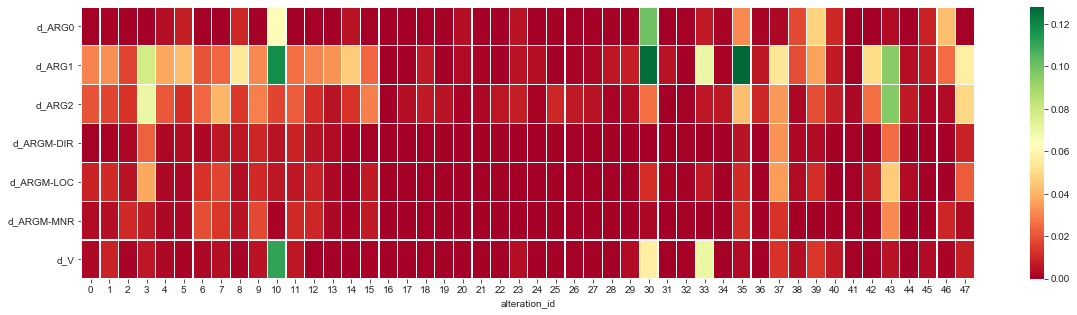

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set_style("ticks", {"xtick.major.color": 'white', "ytick.major.color": 'white'})
#dpi = 72

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='RdYlGn', linewidths = 0.20, annot = False)#, ax=ax)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.gcf().canvas.draw()
    img_arr = np.fromstring(plt.gcf().canvas.tostring_rgb(), 
                        dtype=np.uint8,
                        sep='').reshape((360, 1440, 3))
    return snsplt.get_figure()

pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 150)
pd.options.display.max_rows = 10000

def revert_to_l1(el):
    if type(el) == list or type(el) == np.ndarray: 
        return el
    if len(el[1:-1]):
        el = el.replace('(', '').replace("'", '').replace(' ', '').replace('),', ')').replace(']', '').replace('[', '')
        output = [el_i.split(",") for el_i in el.split(')') if len(el_i)>3]
        if len(output)>1: 
            output = np.concatenate(output)
        return np.unique(output)
    else:
        return []


def disentang_metric(this_df):
    this_df['new_rels'] = this_df['new_rels'].map(revert_to_l1)
    this_df['rel_diff'] = this_df['rel_diff'].map(revert_to_l1)
    rel_types = np.unique(np.concatenate(this_df['new_rels'].array))
    for ty in rel_types:
        concerned = []
        for deps in this_df['new_rels'].array:
            concerned.append(ty in deps)
        this_df[ty] = concerned
    d_rel_types = ['d_'+ty for ty in np.unique(np.concatenate(this_df['rel_diff'].array))]
    for ty in d_rel_types:
        concerned = []
        for deps in this_df['rel_diff'].array:
            concerned.append(str(ty[2:]) in deps)
        this_df[ty] = concerned
    grouped = this_df.groupby('alteration_id')
    
    # print(grouped.mean()[rel_types])
    dis_diffs1 = 0
    for ty in d_rel_types:
        largest2 = np.array(grouped.mean().nlargest(2, ty)[ty].array)
        dis_diffs1 += largest2[0] - largest2[1]
    dis_diffs2 = 0
    for ty in rel_types:
        largest2 = np.array(grouped.mean().nlargest(2, ty)[ty].array)
        dis_diffs2 += largest2[0] - largest2[1]
    sup_dis_diffs1 = 0
    for i in range(48):
        largest2 = np.array(grouped.mean()[d_rel_types].transpose().nlargest(2, i)[i].array)
        sup_dis_diffs1 += largest2[0] - largest2[1]
        print(i, largest2)
    sup_dis_diffs2 = 0
    for i in range(48):
        largest2 = np.array(grouped.mean()[rel_types].transpose().nlargest(2, i)[i].array)
        sup_dis_diffs2 += largest2[0] - largest2[1]
    print("disentanglement scores : {} and {}".format(dis_diffs1, dis_diffs2))
    print("Sup disentanglement scores : {} and {}".format(sup_dis_diffs1, sup_dis_diffs2))
    plt.figure(figsize=(20, 5))
    show_df_hm2(grouped.mean()[d_rel_types].transpose())
    # plt.figure(figsize=(20, 2))
    # show_df_hm2(grouped.mean()[d_rel_types].transpose())
    return dis_diffs1, dis_diffs2

disentang_metric(df)

In [126]:
from torch.utils.tensorboard import SummaryWriter
swriter = SummaryWriter("tb_logs/test_dis")

In [98]:
proportion, tries, scores1, scores2 = 0.5, 50, [], []
for _ in tqdm(range(tries)):
    samples = pd.concat([df[df['alteration_id']==i].sample(frac=proportion) for i in range(48)])
    sc1, sc2 = disentang_metric(samples)
    scores1.append(sc1)
    scores2.append(sc2)
print("Score 1: {}, +-{}".format(np.mean(scores1), np.std(scores1)))
print("Score 2: {}, +-{}".format(np.mean(scores2), np.std(scores2)))

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  2%|█▋                                                                                 | 1/50 [00:00<00:40,  1.22it/s]

  4%|███▎                                                                               | 2/50 [00:01<00:42,  1.13it/s]

  6%|████▉                                                                              | 3/50 [00:02<00:41,  1.13it/s]

  8%|██████▋                                                                            | 4/50 [00:03<00:39,  1.16it/s]

 10%|████████▎                                                                          | 5/50 [00:04<00:38,  1.18it/s]

 12%|█████████▉                                                                         | 6/50 [00:05<00:36,  1.22it/s]

 14%|███████████▌                                                                       | 7/50 [00:05<00:35,  1.21it/s]

 16%|█████████████▎                                                                     | 8/50 [00:06<00:34,  1.23it/s]

 18%|██████████████▉                                                                    | 9/50 [00:07<00:33,  1.24it/s]

 20%|████████████████▍                                                                 | 10/50 [00:08<00:31,  1.25it/s]

 22%|██████████████████                                                                | 11/50 [00:09<00:30,  1.27it/s]

 24%|███████████████████▋                                                              | 12/50 [00:09<00:29,  1.30it/s]

 26%|█████████████████████▎                                                            | 13/50 [00:10<00:27,  1.33it/s]

 28%|██████████████████████▉                                                           | 14/50 [00:11<00:26,  1.35it/s]

 30%|████████████████████████▌                                                         | 15/50 [00:11<00:25,  1.38it/s]

 32%|██████████████████████████▏                                                       | 16/50 [00:12<00:24,  1.41it/s]

 34%|███████████████████████████▉                                                      | 17/50 [00:13<00:22,  1.45it/s]

 36%|█████████████████████████████▌                                                    | 18/50 [00:14<00:22,  1.40it/s]

 38%|███████████████████████████████▏                                                  | 19/50 [00:14<00:21,  1.41it/s]

 40%|████████████████████████████████▊                                                 | 20/50 [00:15<00:20,  1.44it/s]

 42%|██████████████████████████████████▍                                               | 21/50 [00:16<00:20,  1.44it/s]

 44%|████████████████████████████████████                                              | 22/50 [00:16<00:19,  1.44it/s]

 46%|█████████████████████████████████████▋                                            | 23/50 [00:17<00:18,  1.44it/s]

 48%|███████████████████████████████████████▎                                          | 24/50 [00:18<00:17,  1.44it/s]

 50%|█████████████████████████████████████████                                         | 25/50 [00:18<00:17,  1.42it/s]

 52%|██████████████████████████████████████████▋                                       | 26/50 [00:19<00:16,  1.44it/s]

 54%|████████████████████████████████████████████▎                                     | 27/50 [00:20<00:15,  1.44it/s]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:20<00:15,  1.44it/s]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:21<00:14,  1.42it/s]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:22<00:13,  1.43it/s]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:23<00:13,  1.43it/s]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:23<00:12,  1.47it/s]

 66%|██████████████████████████████████████████████████████                            | 33/50 [00:24<00:11,  1.46it/s]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:25<00:10,  1.47it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:25<00:10,  1.46it/s]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:26<00:09,  1.48it/s]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:27<00:08,  1.48it/s]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:27<00:08,  1.47it/s]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:28<00:07,  1.47it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:29<00:06,  1.48it/s]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:29<00:06,  1.44it/s]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:30<00:05,  1.46it/s]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:31<00:04,  1.45it/s]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:31<00:04,  1.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:32<00:03,  1.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:33<00:02,  1.47it/s]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:33<00:02,  1.46it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:34<00:01,  1.46it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:35<00:00,  1.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.39it/s]

Score 1: 0.13728, +-0.024002533199643742
Score 2: 0.4466400000000001, +-0.06397179378444848


In [4]:
# print(np.unique(df['new_deps'].array, return_counts=True))#'root_children_diff',
from tqdm import tqdm
import numpy as np
header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
print(df['diff_dep'].array[116], )

df['diff_dep'] = df['diff_dep'].map(revert_to_l1)
df['new_deps'] = df['new_deps'].map(revert_to_l1)
df['root_children_dep_diff'] = df['root_children_dep_diff'].map(revert_to_l1)
df['new_rels'] = df['new_rels'].map(revert_to_l1)
df['rel_diff'] = df['rel_diff'].map(revert_to_l1)
print(df['diff_dep'].array[0], df['diff_dep'].array[7])

d_dep_types = ['d_'+ty for ty in np.unique(np.concatenate(df['diff_dep'].array))]
for ty in tqdm(d_dep_types):
    concerned = []
    for deps in df['diff_dep'].array.astype(list):
        concerned.append(ty[2:] in deps)
    df[ty] = concerned

dep_types = np.unique(np.concatenate(df['new_deps'].array))
for ty in tqdm(dep_types):
    concerned = []
    for deps in df['new_deps'].array:
        concerned.append(ty in deps)
    df[ty] = concerned
c_dep_types = ['c_'+ty for ty in np.unique(np.concatenate(df['root_children_dep_diff'].array))]
for ty in tqdm(c_dep_types):
    concerned = []
    for deps in df['root_children_dep_diff'].array:
        concerned.append(ty[2:] in deps)
    df[ty] = concerned

rel_types = np.unique(np.concatenate(df['new_rels'].array))
for ty in tqdm(rel_types):
    concerned = []
    for deps in df['new_rels'].array:
        concerned.append(ty in deps)
    df[ty] = concerned
d_rel_types = ['d_'+ty for ty in np.unique(np.concatenate(df['rel_diff'].array))]
for ty in tqdm(d_rel_types):
    concerned = []
    for deps in df['rel_diff'].array:
        concerned.append(ty[2:] in deps)
    df[ty] = concerned



[]


[] ['pobj']


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

 16%|█████████████▎                                                                     | 4/25 [00:00<00:00, 33.42it/s]

 32%|██████████████████████████▌                                                        | 8/25 [00:00<00:00, 34.02it/s]

 52%|██████████████████████████████████████████▋                                       | 13/25 [00:00<00:00, 36.98it/s]

 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:00<00:00, 38.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:00<00:00, 39.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 39.23it/s]


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 11%|█████████▏                                                                         | 3/27 [00:00<00:01, 22.62it/s]

 22%|██████████████████▍                                                                | 6/27 [00:00<00:00, 23.57it/s]

 33%|███████████████████████████▋                                                       | 9/27 [00:00<00:00, 24.41it/s]

 44%|████████████████████████████████████▍                                             | 12/27 [00:00<00:00, 23.13it/s]

 56%|█████████████████████████████████████████████▌                                    | 15/27 [00:00<00:00, 23.29it/s]

 67%|██████████████████████████████████████████████████████▋                           | 18/27 [00:00<00:00, 24.20it/s]

 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [00:00<00:00, 24.22it/s]

 89%|████████████████████████████████████████████████████████████████████████▉         | 24/27 [00:00<00:00, 24.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 19.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 22.17it/s]

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  9%|███████▌                                                                           | 2/22 [00:00<00:01, 14.53it/s]

 18%|███████████████                                                                    | 4/22 [00:00<00:01, 15.12it/s]

 27%|██████████████████████▋                                                            | 6/22 [00:00<00:01, 15.42it/s]

 36%|██████████████████████████████▏                                                    | 8/22 [00:00<00:00, 16.21it/s]

 45%|█████████████████████████████████████▎                                            | 10/22 [00:00<00:00, 15.97it/s]

 55%|████████████████████████████████████████████▋                                     | 12/22 [00:00<00:00, 16.22it/s]

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:00<00:00, 16.57it/s]

 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:00<00:00, 17.79it/s]

 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:01<00:00, 17.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.56it/s]

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 19%|███████████████▌                                                                   | 3/16 [00:00<00:00, 23.14it/s]

 38%|███████████████████████████████▏                                                   | 6/16 [00:00<00:00, 22.07it/s]

 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:00<00:00, 21.84it/s]

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:00<00:00, 20.55it/s]

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:00<00:00, 20.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.36it/s]

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 29%|████████████████████████                                                            | 2/7 [00:00<00:00, 17.59it/s]

 57%|████████████████████████████████████████████████                                    | 4/7 [00:00<00:00, 17.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.82it/s]

In [19]:


header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 150)
pd.options.display.max_rows = 10000


grouped = df.groupby('alteration_id')
# print(grouped.mean()[dep_types])
print('************ ANY ****************')
print('       *** Values ***')
print(grouped.mean()[dep_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[dep_types].idxmax())
hm_df1 = grouped.mean()[dep_types].transpose()
print('************ ROOT ****************')
print('       *** Values ***')
print(grouped.mean()[c_dep_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[c_dep_types].idxmax())
hm_df2 = grouped.mean()[c_dep_types].transpose()
print('************ relation differences ****************')
print('       *** Values ***')
print(grouped.mean()[rel_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[rel_types].idxmax())
hm_df3 = grouped.mean()[rel_types].transpose()
print('************ relation Appearances ****************')
print('       *** Values ***')
print(grouped.mean()[d_rel_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[d_rel_types].idxmax())
hm_df4 = grouped.mean()[d_rel_types].transpose()

************ ANY ****************
       *** Values ***
acl          0.013
acomp        0.081
advcl        0.009
advmod       0.042
agent        0.003
amod         0.342
appos        0.003
attr         0.019
aux          0.124
auxpass      0.005
cc           0.036
compound     0.016
conj         0.036
det          0.003
dobj         0.352
expl         0.003
mark         0.003
neg          0.007
nsubj        0.012
nsubjpass    0.005
nummod       0.030
pcomp        0.001
pobj         0.314
poss         0.105
prep         0.317
prt          0.048
xcomp        0.086
dtype: float64
       ***  IDX   ***
acl          30
acomp        10
advcl        30
advmod       30
agent        10
amod         30
appos        10
attr         10
aux          30
auxpass      10
cc           30
compound      3
conj         30
det          33
dobj         10
expl         30
mark         30
neg          30
nsubj        30
nsubjpass    30
nummod       30
pcomp        37
pobj         10
poss         10
prep      

************ relation differences ****************
       *** Values ***
ARG0        0.397
ARG1        0.401
ARG2        0.238
ARG4        0.008
ARGM-ADV    0.011
ARGM-COM    0.004
ARGM-DIR    0.114
ARGM-EXT    0.009
ARGM-GOL    0.004
ARGM-LOC    0.259
ARGM-MNR    0.117
ARGM-NEG    0.006
ARGM-PRD    0.001
ARGM-PRP    0.001
ARGM-TMP    0.003
V           0.168
dtype: float64
       ***  IDX   ***
ARG0        10
ARG1        10
ARG2        10
ARG4        30
ARGM-ADV    37
ARGM-COM    39
ARGM-DIR    10
ARGM-EXT    10
ARGM-GOL    11
ARGM-LOC    10
ARGM-MNR    10
ARGM-NEG    30
ARGM-PRD    35
ARGM-PRP    10
ARGM-TMP    30
V           10
dtype: int64


************ relation Appearances ****************
       *** Values ***
d_ARG0        0.100
d_ARG1        0.128
d_ARG2        0.096
d_ARGM-DIR    0.033
d_ARGM-LOC    0.046
d_ARGM-MNR    0.031
d_V           0.111
dtype: float64
       ***  IDX   ***
d_ARG0        30
d_ARG1        35
d_ARG2        43
d_ARGM-DIR    37
d_ARGM-LOC    43
d_ARGM-MNR    43
d_V           10
dtype: int64


In [9]:

pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 150)
pd.options.display.max_rows = 10000
for line in df[df['alteration_id'] == 43][['original', 'altered']].iterrows():    
    if line[1]['original'] != line[1]['altered']:
        print(line[1]['original'], line[1]['altered'])

 a man is sitting down in a park ..   a man is sitting down in front of a building .. 
 a man is trying to get his car ..   a man is trying to get to his baby .. 
 a man is looking at a boy ..   a man is looking at a large crowd .. 
 a worker is sitting at a park ..   a worker is sitting at a bar .. 
 a man is walking on a sidewalk ..   a man is walking on a street .. 
 a man is looking at a tree ..   a man is looking at a long day .. 
 a man is waiting for a game ..   a man is waiting for a performance .. 
 a man is in a blue jacket ..   a man is in a blue shirt .. 
 a man is looking at a boy ..   a man is looking at a <?> .. 
 a man is playing in a field ..   a man is playing in a yard .. 
 a man with a hat is laying down ..   a man with a hat is jumping .. 
 a group of people are walking ..   a group of people are walking down the grass .. 
 a man is trying to get his car ..   a man is trying to get home .. 
 a man is looking at a boy ..   a man is looking at a large crowd .. 
 a wo

In [23]:
#df.to_csv('Autoreg5stats2.csv')

print(list(grouped.mean()[dep_types].max().index))

['acl', 'acomp', 'advcl', 'advmod', 'agent', 'amod', 'appos', 'attr', 'aux', 'auxpass', 'cc', 'compound', 'conj', 'det', 'dobj', 'expl', 'mark', 'neg', 'nsubj', 'nsubjpass', 'nummod', 'pcomp', 'pobj', 'poss', 'prep', 'prt', 'xcomp']


In [3]:
pd.read_csv('Autoreg5stats.csv')

NameError: name 'pd' is not defined

<Figure size 1440x720 with 0 Axes>

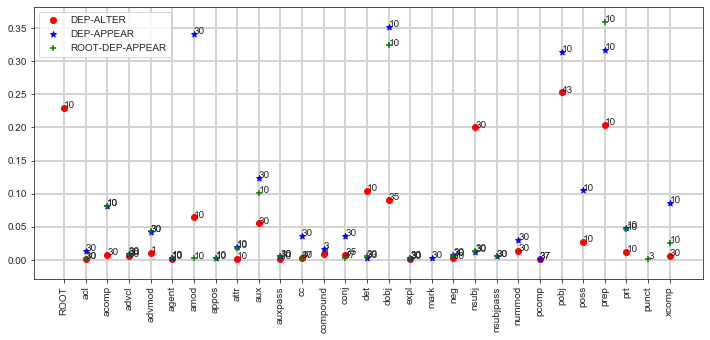

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
# hm_df1.style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'})
def show_df_hm1(df):
    plt.imshow(df, cmap ="RdYlBu") 
      
    # Displaying a color bar to understand 
    # which color represents which range of data 
    plt.colorbar() 
      
    # Assigning labels of x-axis  
    # according to dataframe 
    plt.xticks(range(len(df.axes[1])), df.columns) 
      
    # Assigning labels of y-axis  
    # according to dataframe 
    plt.yticks(range(len(df.axes[0])), df.index) 
      
    # Displaying the figure 
    plt.show() 
def show_df_sp(dfs):
    all_dep_labs = []
    for grp in dfs:
        # print([lab.split('_')[-1] for lab in list(grp.max().index)])
        all_dep_labs = list(np.union1d([lab.split('_')[-1] for lab in list(grp.max().index)], all_dep_labs))
    fig, ax = plt.subplots(figsize=(12,5))
    for grp, color, stat_name, mark in zip(dfs, ['red', 'blue', 'green'], ['DEP-ALTER', 'DEP-APPEAR', 'ROOT-DEP-APPEAR'],
                                     ['o', '*', '+']):

        vals = list(grp.max())
        dep_labs = [lab.split('_')[-1] for lab in list(grp.max().index)]
        dep_idx = [all_dep_labs.index(lab) for lab in dep_labs]
        lv_ids = list(grp.idxmax())
        
        ax.scatter(dep_idx, vals,c=color, label=stat_name, marker=mark)
    
        for i, txt in enumerate(lv_ids):
            ax.annotate(txt, (dep_idx[i], vals[i]))
    ax.set(xticks=range(len(all_dep_labs)), xticklabels=all_dep_labs)#, rotation='vertical') 
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.grid(color='lightgray', linestyle='-', linewidth=2)
    ax.legend()
          
        # Displaying the figure 
    plt.show() 
    return fig
def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = False)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()

sns.set_style("ticks", {"xtick.major.color": 'white', "ytick.major.color": 'white'})
plt.figure(figsize=(20, 10))
show_df_sp([grouped.mean()[d_dep_types],grouped.mean()[dep_types],
           grouped.mean()[c_dep_types]]).savefig("output.png")

#d_dep_types: diff_dep, dep_types: new_deps, c_dep_types: root_children_dep_diff
# sns_plot = show_df_hm2(hm_df1)
# sns_plot.savefig("output.png")

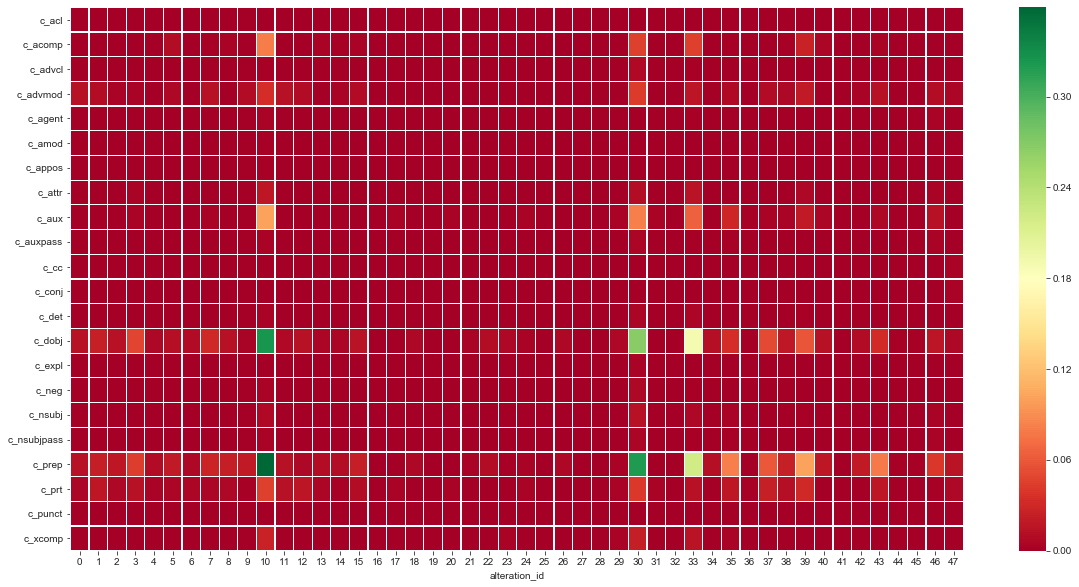

In [134]:
 
plt.figure(figsize=(20, 10))
show_df_hm2(hm_df2)

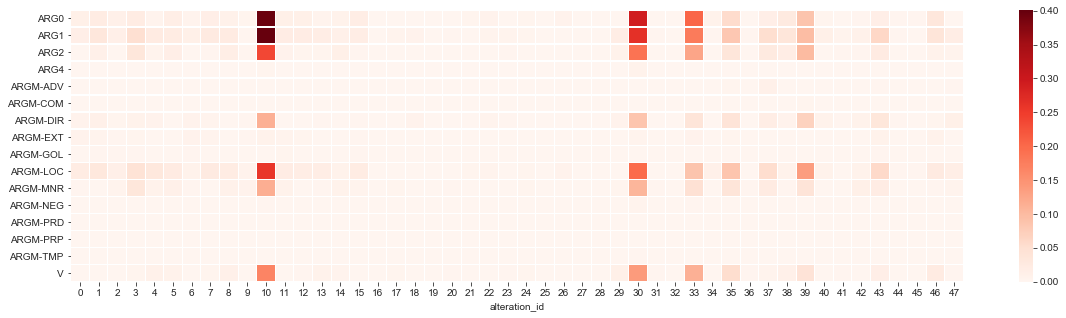

In [14]:
 
sns_plot = plt.figure(figsize=(20, 5))
show_df_hm2(hm_df3)
sns_plot.savefig("new_rels.png")

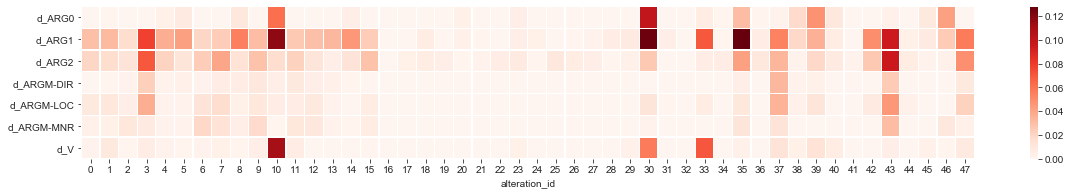

In [18]:
 
sns_plot = plt.figure(figsize=(20, 2.8))
show_df_hm2(hm_df4)
sns_plot.savefig("rel_diff.png")

In [ ]:
[0, 1, 3, 6, 7, 9, 11, 12, 15, 30, 35, 37, 39, 42, 43, 47]